In [1]:
# -*- coding: utf-8 -*-

import os
import pandas as pd
import numpy as np
from collections import Counter
import nltk
from nltk import sent_tokenize, word_tokenize
from string import punctuation
import string
from nltk.corpus import stopwords
stop = set(stopwords.words('russian'))
# from nltk.stem import SnowballStemmer
from collections import Counter
# stemmer = SnowballStemmer('russian')
import os
import re


from random import shuffle

from libs.utils import preprocessing, preprocessing_2, convert_float
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload

%autoreload 2

## Data Preparation

In [3]:
col_type={'_id': str,
       'cont_num':str,
       'sign_date':str,
       'custom_regnum':str,
       'product_name':str,
       'okdp_code':str,
       'okei_code':str,
       'quantity':float,
       'price':float,
       'sum':float
       }

df = pd.read_csv('datascript/medical_2012.csv', sep=';',dtype=col_type)
df.head()

,_id,cont_num,sign_date,custom_regnum,product_name,okdp_code,okei_code,quantity,price,sum
0,12798676,0318300093212000003,2012-01-03,03183000932,Гидрокортизон-Рихтер сусп для в/м и внутрисуст...,2423219,778,40.0,84.53,3381.20
1,12798677,0318300093212000003,2012-01-03,03183000932,Лопирел таб. п/об пленочн. 75мг №28,2423219,778,90.0,689.57,62061.30
2,12798708,0318300093212000003,2012-01-03,03183000932,Плавикс таб. п/о 300мг №10,2423219,778,6.0,2308.63,13851.78
3,12798709,0318300093212000003,2012-01-03,03183000932,"Фраксипарин р-р для п/к введ. 9,5тыс. анти-Ха ...",2423219,778,10.0,1484.56,14845.60
4,12798710,0318300093212000003,2012-01-03,03183000932,Тромбофлюкс лиоф. пригот. р-ра в/в и в/а введ....,2423219,778,20.0,8472.64,169452.80


In [4]:
len(df)

127786

## Countries

In [5]:
import pandas as pd
data_xls = pd.read_excel('data/countries.xls', 'grls2', index_col=0)
# data_xls.to_csv('countries.csv', encoding='utf-8')

data_xls.drop('Номер регистрационного удостоверения', inplace=True)

countries = set([x.lower() for x in data_xls['Unnamed: 6'] if (isinstance(x, str) and x[0] != ' ')])
countries.remove('~')
countries

{'австралия',
 'австрия',
 'азербайджан',
 'аргентина',
 'армения',
 'беларусь',
 'бельгия',
 'болгария',
 'босния и герцеговина',
 'бразилия',
 'британские виргинские острова',
 'великобритания',
 'венгрия',
 'вьетнам',
 'германия',
 'гонконг (кнр)',
 'греция',
 'грузия',
 'дания',
 'египет',
 'израиль',
 'индия',
 'индонезия',
 'иордания',
 'иран',
 'ирландия',
 'исландия',
 'испания',
 'италия',
 'казахстан',
 'канада',
 'кипр',
 'китай',
 'кнр',
 'корея',
 'корея южная',
 'куба',
 'кыргызская республика',
 'латвия',
 'литва',
 'лихтенштейн',
 'люксембург',
 'малайзия',
 'мальта',
 'мексика',
 'нидерландские антилы',
 'нидерланды',
 'новая зеландия',
 'норвегия',
 'объединенные арабские эмираты',
 'оман',
 'пакистан',
 'панама',
 'перу',
 'польша',
 'португалия',
 'пуэрто-рико',
 'пуэрто-рико (сша)',
 'пуэрто-рико, сша',
 'республика беларусь',
 'республика болгария',
 'республика казахстан',
 'республика корея',
 'республика куба',
 'республика маврикий',
 'республика македония',
 

In [6]:
def check_country(s):
    for c in countries:
        if c in s:
            return c
    return pd.np.nan

df['country'] = df['product_name'].apply(lambda x : check_country(x))

In [7]:
df.columns

Index(['_id', 'cont_num', 'sign_date', 'custom_regnum', 'product_name',
       'okdp_code', 'okei_code', 'quantity', 'price', 'sum', 'country'],
      dtype='object')

## List of all pharma names 

In [8]:
data_ff = data_xls[['Unnamed: 7', 'Unnamed: 9']]

data_ff.reset_index(inplace=True, drop=True)
data_ff['trade'] = data_ff['Unnamed: 7']
data_ff['official'] = data_ff['Unnamed: 9']
data_ff.drop(['Unnamed: 7', 'Unnamed: 9'], axis=1, inplace=True)
data_ff.head(30)
import re
delimiters = '®', '(',')', '~', '-', ':', '.', ',', '№', '+', '[',']', '{', '}', ' '
# example = "stackoverflow (c) is awesome... isn't it?"
regexPattern = '|'.join(map(re.escape, delimiters))
trade_to_official_dic = dict()
for trade_name, official_name in zip(list(data_ff['trade']), list(data_ff['official'])):
    if (isinstance(trade_name, float) or isinstance(official_name, float)):
        continue
    trades = re.split(regexPattern, trade_name)
    officials = re.split(regexPattern, official_name)
    max_word_trade = ''
    for trade in trades:
        if len(trade) > len(max_word_trade):
            max_word_trade = trade
    max_word_official = ''
    for official in officials:
        if len(official) > len(max_word_official):
            max_word_official = official
    trade_to_official_dic[max_word_trade] = max_word_official

# re.split(regexPattern, example)

#processing
data_ff['trade'] = data_ff['trade'].apply(lambda x : str(x).lower())
data_ff['official'] = data_ff['official'].apply(lambda x : str(x).lower())
delimiters = '®', '(',')', '~', '-', ':', '.', ',', '№', '+', '[',']', '{', '}', ' '
data_ff['official']=data_ff['official'].map(lambda x: re.sub('\d+', '',str(x)))
data_ff['trade']=data_ff['trade'].map(lambda x: re.sub('\d+', '',str(x)))
data_ff['trade']=data_ff['trade'].apply(lambda x: re.split(regexPattern, str(x)))
data_ff['official']=data_ff['official'].apply(lambda x: re.split(regexPattern, str(x)))
data_ff['official']=data_ff['official'].map(lambda x: [z for z in x if z != ''])
data_ff['trade']=data_ff['trade'].map(lambda x: [z for z in x if z != ''])

from tqdm import tqdm

set_of_meds = set()
for i in tqdm(range(len(data_ff))):
    for w in data_ff.loc[i, 'trade']:
        set_of_meds.add(w)
    for w in data_ff.loc[i, 'official']:
        set_of_meds.add(w)

100%|██████████| 61605/61605 [00:00<00:00, 74943.17it/s]


In [9]:
### Preprocessing

df = preprocessing(df)
df = preprocessing_2(df)
df.reset_index(inplace=True, drop=True)

In [10]:
len(df)



110000

In [11]:
df.head()

,_id,product_name,quantity,price,sum,country,name_norm,mg_ml,ml,mg,g,number,name_word,type,name_del,name_del_text,len
0,12798676,Гидрокортизон-Рихтер сусп для в/м и внутрисуст...,40.0,84.53,3381.20,NaN,гидрокортизонрихтер сусп вм внутрисуст вв мгмл...,25.0,5.0,NaN,NaN,№1,"[гидрокортизонрихтер, сусп, вм, внутрисуст, вв...",liquid,"[гидрокортизонрихтер, внутрисуст]",гидрокортизонрихтер вм внутрисуст вв мгмл мл,2
1,12798677,Лопирел таб. п/об пленочн. 75мг №28,90.0,689.57,62061.30,NaN,лопирел таб поб пленочн мг,NaN,NaN,75.0,NaN,№28,"[лопирел, таб, поб, пленочн, мг]",tablet,"[лопирел, пленочн]",лопирел поб пленочн мг,2
2,12798708,Плавикс таб. п/о 300мг №10,6.0,2308.63,13851.78,NaN,плавикс таб по мг,NaN,NaN,300.0,NaN,№10,"[плавикс, таб, по, мг]",tablet,[плавикс],плавикс по мг,1
3,12798709,"Фраксипарин р-р для п/к введ. 9,5тыс. анти-Ха ...",10.0,1484.56,14845.60,NaN,фраксипарин рр пк введ тыс антиха мемл шприц...,NaN,0.3,NaN,NaN,№10,"[фраксипарин, рр, пк, введ, тыс, антиха, мемл,...",liquid,"[фраксипарин, пк, тыс, антиха, мемл, шприц, од...",фраксипарин пк введ тыс антиха мемл шприц одн...,9
4,12798710,Тромбофлюкс лиоф. пригот. р-ра в/в и в/а введ....,20.0,8472.64,169452.80,NaN,тромбофлюкс лиоф пригот рра вв ва введ млн ...,NaN,1.5,NaN,NaN,№1,"[тромбофлюкс, лиоф, пригот, рра, вв, ва, введ,...",liquid,"[тромбофлюкс, лиоф, пригот, ва, млн, ме]",тромбофлюкс лиоф пригот вв ва введ млн ме,6


In [12]:
def transform_from_trade_to_orig(list_of_words):
    new_list = list()
    for word in list_of_words:
        if word in trade_to_official_dic.keys():
            new_list.append(trade_to_official_dic[word])
        else:
            new_list.append(word)
    return new_list

df['name_del'] = df['name_del'].apply(transform_from_trade_to_orig)

In [13]:
df.head()

,_id,product_name,quantity,price,sum,country,name_norm,mg_ml,ml,mg,g,number,name_word,type,name_del,name_del_text,len
0,12798676,Гидрокортизон-Рихтер сусп для в/м и внутрисуст...,40.0,84.53,3381.20,NaN,гидрокортизонрихтер сусп вм внутрисуст вв мгмл...,25.0,5.0,NaN,NaN,№1,"[гидрокортизонрихтер, сусп, вм, внутрисуст, вв...",liquid,"[гидрокортизонрихтер, внутрисуст]",гидрокортизонрихтер вм внутрисуст вв мгмл мл,2
1,12798677,Лопирел таб. п/об пленочн. 75мг №28,90.0,689.57,62061.30,NaN,лопирел таб поб пленочн мг,NaN,NaN,75.0,NaN,№28,"[лопирел, таб, поб, пленочн, мг]",tablet,"[лопирел, пленочн]",лопирел поб пленочн мг,2
2,12798708,Плавикс таб. п/о 300мг №10,6.0,2308.63,13851.78,NaN,плавикс таб по мг,NaN,NaN,300.0,NaN,№10,"[плавикс, таб, по, мг]",tablet,[плавикс],плавикс по мг,1
3,12798709,"Фраксипарин р-р для п/к введ. 9,5тыс. анти-Ха ...",10.0,1484.56,14845.60,NaN,фраксипарин рр пк введ тыс антиха мемл шприц...,NaN,0.3,NaN,NaN,№10,"[фраксипарин, рр, пк, введ, тыс, антиха, мемл,...",liquid,"[фраксипарин, пк, тыс, антиха, мемл, шприц, од...",фраксипарин пк введ тыс антиха мемл шприц одн...,9
4,12798710,Тромбофлюкс лиоф. пригот. р-ра в/в и в/а введ....,20.0,8472.64,169452.80,NaN,тромбофлюкс лиоф пригот рра вв ва введ млн ...,NaN,1.5,NaN,NaN,№1,"[тромбофлюкс, лиоф, пригот, рра, вв, ва, введ,...",liquid,"[тромбофлюкс, лиоф, пригот, ва, млн, ме]",тромбофлюкс лиоф пригот вв ва введ млн ме,6


# ------------------------------

In [14]:
import pickle

a = set_of_meds

with open('set_of_meds.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('set_of_meds.pickle', 'rb') as handle:
    b = pickle.load(handle)

print(a == b)

True



## Частотный анализ и дополнительная чистка

In [15]:
del_list_2 = ["ин", "производные", "картонные", "картонные", "фл", "кислота",
              "пачки", "шт", "лечения", "приготовления", "группы", "флаконы", "ингаляционного", "контурные",
             "упаковки", "уп", "о", "в", "менее", "раствора", "рра","»","заменители", "пластиковые"
              "завод", "годности", "упаковке", "п", "х", "срок", "–", "мнн", "оао", "а",
             "инф", "форма", "комплекте", "дозировка", "страна", "препаратов", "лек", "темного", "производитель", 
             "ряда", "зао", "препарат", "стекла", "или", "мкгмл", "ряда", "жидкость", "от", "д", "пр", "лтд", "кол", "ооо", "их"]
del_list_2 += list(countries)

In [16]:
def my_func(a):
    return [x for x in a if x not in del_list_2]

In [17]:
df['name_del'] = df['name_del'].apply(lambda x : my_func(x))

In [18]:
from collections import Counter
words = list()
for i in range(len(df)):
    words += df.loc[i, 'name_del']
count = Counter(words)
count.most_common(100)

[('пирацетам', 3934),
 ('галоперидол', 2573),
 ('аминазин', 2493),
 ('депакин', 2020),
 ('амитриптилин', 1957),
 ('винпоцетин', 1888),
 ('феназепам', 1771),
 ('фенотиазина', 1689),
 ('бензодиазепина', 1673),
 ('бромкамфора', 1634),
 ('паркинсонизма', 1534),
 ('трамадол', 1520),
 ('дроперидол', 1447),
 ('карбамазепин', 1386),
 ('Аминосалициловая', 1330),
 ('вальпроевая', 1327),
 ('ячейковые', 1321),
 ('пролонг', 1212),
 ('мексидол', 1170),
 ('церебролизин', 1147),
 ('хлорпротиксен', 1128),
 ('церетон', 1116),
 ('хроно', 1115),
 ('Вода', 1105),
 ('клопиксол', 983),
 ('фентанил', 953),
 ('пропофол', 944),
 ('сонапакс', 925),
 ('цераксон', 919),
 ('Изосорбида', 892),
 ('промедол', 887),
 ('рисперидон', 857),
 ('конвулекс', 854),
 ('глицин', 833),
 ('фенибут', 828),
 ('севоран', 819),
 ('кордиамин', 809),
 ('сульпирид', 756),
 ('завод', 739),
 ('хроносфера', 732),
 ('бетагистин', 723),
 ('кетамин', 718),
 ('сибазон', 717),
 ('', 715),
 ('инфузий', 715),
 ('эглонил', 708),
 ('фарма', 702),
 

In [19]:
len([x for x in count.keys() if len(x) > 3])

10617

In [20]:
sum(count.values()), len(count.keys())

(226120, 11277)

### old dict vs new dict from file

In [21]:
#old dict
df['len']=df['name_del'].apply(lambda x : len(x))
df_len1 = df[df['len'] == 1]
df_len1['name'] = df_len1['name_del'].map(lambda x: x[0])

old_med_dic=df_len1.loc[:,'name']
old_med_dic=pd.DataFrame(old_med_dic.drop_duplicates())
old_med_dic['class']=range(0,len(old_med_dic['name']))
old_med_dic['index']=old_med_dic['class']
old_med_dic=old_med_dic.set_index('index')

In [22]:
import editdistance
from tqdm import tqdm
# editdistance.eval()
unfound_matches = list()
for old_word in tqdm(list(old_med_dic['name'])):
    flag = False
    for new_word in set_of_meds:
        if editdistance.eval(old_word, new_word) <= 2:
            flag = True
            continue
    if not flag:
        unfound_matches.append(old_word)
            

100%|██████████| 2952/2952 [01:55<00:00, 25.46it/s]


In [23]:
print(len(unfound_matches), unfound_matches)

876 ['паркинсонизма', 'анальгетики', 'винпоцетинтаблетки', 'толперизонobl', 'конвулекстаблетки', 'винпоцетинакос', 'винпоцетинсар', 'мидокалмрихтер', 'системупрочиекетанов', 'системупрочиенайз', 'системупрочиенифедипин', 'противосудорожныеношпа', 'системупрочиетавегил', 'системупрочиефлюколдекс', 'дроперидолраствор', 'новопассит', 'бифиформкапс', 'прочиеотменавыбрать', 'галоперидолферейн', 'пирацетамциннаризин', 'метионилглутамилгистидилфенилаланилпролилглицилпролин', 'алифатического', 'средствавлияющие', 'галоперидолгалоперидолферейнмгмл', 'диазепамреланиум', 'наркозаотменавыбрать', 'бромокриптинрихтер', 'пирацетамвиал', 'нейролегические', 'сероквельпролонг', 'модитендепо', 'пропофоллипуро', 'прокаинсульфокамфорная', 'психотропных', 'никотиноилгаммааминомасляная', 'тиопенталнатрий', 'глицинмхфп', 'пирацетамрихтер', 'финлепсинретард', 'трамадолтрамадол', 'парацетамолтрамадол', 'дроперидолдроперидол', 'клофелинтаб', 'галоперидолратиофарм', 'леводопакарбидопа', 'пропофолкаби', 'депакинхр

### meds from file

In [24]:
intersection_meds = set()
not_intersection_meds = set()
for c in count.keys():
    if c in set_of_meds:
        intersection_meds.add(c)
    else:
        not_intersection_meds.add(c)

In [25]:
len(intersection_meds)

2416

In [26]:
len(not_intersection_meds)

8861

In [27]:
not_intersection_meds

{'',
 'презартин',
 'ложкой',
 'ограничения',
 'дляинъ',
 'фереин',
 'кислотакурантилдротавериндимедролфезипамуголь',
 'внутрибрюшинного',
 'анексатрр',
 'ул',
 'акатино',
 'стимулотонмг',
 'бромгидрохлорфенилбензодеазепин',
 'морфиннаркотинпапаверинкодеинтебаин',
 'речевого',
 'оксибутирати',
 'мц',
 'водорастворимых',
 'холитилинхолина',
 'дюрогезие',
 'цераксонмл',
 'глазной',
 'сосудорасширяющим',
 'зуклопентиксолклопиксолтаблетки',
 'вальпроатаna',
 'млпачка',
 'химических',
 'дек',
 'распылителем',
 'валерины',
 'безигол',
 'препратов',
 'относящихся',
 'перчатки',
 'фармпроект',
 'уменьшения',
 'эсциталопрамципралекс',
 'кот',
 'фильтрпакеты',
 'хофманнля',
 'иммодиум',
 'улучшающий',
 'нижфарммосковский',
 'прочиебетагистин',
 'миокарда',
 'табд',
 'внутримышеного',
 'инсультов',
 'логбуз',
 'контурная',
 'барбитураты',
 'бисопрололпрана',
 'внутриглазн',
 'италиа',
 'капсмгмг',
 'германиявып',
 'периндоприлрихтер',
 'пролонгтаблетки',
 'контейнеры',
 'азафентаб',
 'обеспечению

In [28]:
for c in not_intersection_meds:
    if c not in unfound_matches:
        del count[c]

In [29]:
count.most_common(50)

[('пирацетам', 3934),
 ('галоперидол', 2573),
 ('аминазин', 2493),
 ('депакин', 2020),
 ('амитриптилин', 1957),
 ('винпоцетин', 1888),
 ('феназепам', 1771),
 ('бромкамфора', 1634),
 ('паркинсонизма', 1534),
 ('трамадол', 1520),
 ('дроперидол', 1447),
 ('карбамазепин', 1386),
 ('вальпроевая', 1327),
 ('пролонг', 1212),
 ('мексидол', 1170),
 ('церебролизин', 1147),
 ('хлорпротиксен', 1128),
 ('церетон', 1116),
 ('хроно', 1115),
 ('клопиксол', 983),
 ('фентанил', 953),
 ('пропофол', 944),
 ('сонапакс', 925),
 ('цераксон', 919),
 ('промедол', 887),
 ('рисперидон', 857),
 ('конвулекс', 854),
 ('глицин', 833),
 ('фенибут', 828),
 ('севоран', 819),
 ('кордиамин', 809),
 ('сульпирид', 756),
 ('хроносфера', 732),
 ('бетагистин', 723),
 ('кетамин', 718),
 ('сибазон', 717),
 ('инфузий', 715),
 ('эглонил', 708),
 ('фарма', 702),
 ('хлорпромазин', 693),
 ('рисполепт', 679),
 ('неулептил', 676),
 ('мидокалм', 648),
 ('кветиапин', 622),
 ('кавинтон', 585),
 ('кортексин', 583),
 ('морфин', 581),
 ('ци

In [30]:
df['name_del_text']=df['name_del'].apply(lambda x: ' ' + ' '.join(x) + ' ')
df['len']=df['name_del'].apply(lambda x: len(x))

In [31]:
len(df)

110000

## Новая кластеризация

In [32]:
med_dic = dict()
klass = 0
for c in count.keys():
    med_dic[c] = klass
    klass += 1

### критическая дистанция левенштейна - 1

In [33]:
%%time
import editdistance
from collections import defaultdict

med_dic_list = list(med_dic.keys())
typo_dict = defaultdict(str)

for i in range(len(med_dic_list) - 1):
    if typo_dict[med_dic_list[i]] == '':
        typo_dict[med_dic_list[i]] =med_dic_list[i]
    for j in range(i + 1, len(med_dic_list)):
        if (editdistance.eval(med_dic_list[i], med_dic_list[j]) == 1):
            try:
                print(med_dic_list[j], med_dic_list[i])
                typo_dict[med_dic_list[j]] =med_dic_list[i]
                del med_dic[med_dic_list[j]]
            except KeyError:
                pass

к пк
пак пк
пд пк
ск пк
мк пк
пм пк
тс тыс
на ва
ка ва
са ва
вс ва
ра ва
ви ва
мн млн
бензилпенициллин бензилпенициллина
при прим
прам прим
прик прим
ципрофлоксацина ципрофлоксацин
квитаб квиктаб
лидокаин лидокаина
ср св
со св
фв св
мв св
сп св
ск св
ст св
са св
си св
нв св
сн св
цв св
бв св
кв св
амитриптилина амитриптилин
дроперидола дроперидол
глутаминовая глютаминовая
пирацетама пирацетам
трифтазина трифтазин
фенибута фенибут
паркенсонизма паркинсонизма
паркисонизма паркинсонизма
паркинсонизм паркинсонизма
допамин допмин
тиоридазина тиоридазин
хлорпромазина хлорпромазин
пароксетина пароксетин
флувоксамина флувоксамин
т л
м л
к л
s л
б л
р л
ф л
n л
c л
ц л
лс л
x л
э л
бл л
i л
a л
f л
— л
b л
e л
k л
е л
ч л
l л
r л
у л
q л
хл л
m л
z л
h л
v л
d л
налбуфина налбуфин
бетагистина бетагистин
кальций кальция
цр хр
гр хр
р хр
ср хр
мр хр
хл хр
чр хр
деко депо
толперазонobl толперизонobl
карнитин карнитина
фентанила фентанил
кетамина кетамин
морфина морфин
бензонала бензонал
гр цр
р цр

масла масле
растворы растворе
люголя люголь
мн мк
небиволол небиволола
рос пос
артикаина артикаин
ортофер ортофен
бетагестинбетасерк бетагистинбетасерк
карнитен карнитин
рингер рингера
у r
q r
m r
z r
h r
v r
d r
рп ра
ро ра
буторфанол буторфанола
гента дента
бф убф
бв бф
био биол
бв цв
кв цв
ценральную цетральную
q у
m у
z у
h у
v у
d у
зверобой зверобоя
фсп фс
m q
z q
h q
v q
d q
ро рос
амиксин амиксид
лимон лимона
z m
h m
v m
d m
мн эн
нерыную нерную
ценральную центальную
h z
v z
d z
комби комб
v h
d h
d v
ро рп
бетагестизин бетагастизин
кв бв
Wall time: 19.8 s


In [34]:
len(typo_dict)

3291

In [35]:
len(med_dic)

2972

### стопслова

In [36]:
stopwords = [('п', 71944),
 ('ц', 22922),
 ('дства', 8625),
 ('едства', 8619),
 ('действ', 5499),
 ('лек', 3713),
 ('систем', 3711),
 ('цен', 3222),
 ('гр', 2463),
 ('инг', 2007),
 ('упаковки', 1637),
 ('лекарств', 1421),
 ('фарм', 1374),
 ('ингаляционного', 894),
 ('лп', 852),
 ('прам', 843),
 ('препаратов', 658),
 ('комплекте', 646),
 ('наименован', 331),
 ('действующих', 326),
 ('включая', 276),
 ('шприц', 264),
 ('противосуд', 174),
 ('наркотических', 97),
 ('нейролептические', 87),
 ('вода', 81),
 ('on', 75),
 ('анестезии', 58),
 ('медикаменты', 57),
 ('прочих', 42),
 ('вегетативную', 39),
 ('брал', 39),
 ('риской', 39),
 ('системы', 38),
 ('действующе', 34),
 ('лекарства', 33),
 ('седотивные', 30),
 ('нейролептики', 30),
 ('сильнодействующие', 26),
 ('анальгетики', 25)]

In [37]:
for s in stopwords:
    if s[0] in med_dic:
        del med_dic[s[0]]

In [38]:
len(med_dic)

2957

In [39]:
del_keys = list()
for key in med_dic.keys():
    if len(key) < 4:
        del_keys.append(key)
for key in del_keys:
    del med_dic[key]

In [40]:
len(med_dic)

2923

## Matrix of distances

In [41]:
dist = np.zeros((len(med_dic), len(med_dic)))
med_dic_list = list(med_dic)

In [42]:
%%time
import editdistance

for i in tqdm(range(len(med_dic_list) - 1)):
    dist[i][i] = 0
    for j in range(i + 1, len(med_dic_list)):
        dist[i][j] = editdistance.eval(med_dic_list[i], med_dic_list[j])
        dist[j][i] = dist[i][j]

100%|██████████| 2922/2922 [00:22<00:00, 128.58it/s]

Wall time: 22.7 s


### very efficient : 11s vs 5m13s

In [43]:
np.save('lev_distances.np', dist)

## Groupization

In [46]:
#### name_del fixing typos:
def fixed(word):
    if word in typo_dict.keys():
        return typo_dict[word]
    return word

def fix_typo(l):
    new_list = list()
    for word in l:
        new_list.append(fixed(word))
    return new_list
    

In [47]:
df['name_del'] = df['name_del'].apply(lambda x: [s for s in x if len(s) > 3])

In [48]:
%%time
df['name_del'] = df['name_del'].apply(lambda x: fix_typo(x))

Wall time: 220 ms


In [49]:
df.to_csv('new_medical_2012.csv', encoding='utf8')

In [50]:
df = pd.read_csv('new_medical_2012.csv', encoding='utf8')

In [51]:
df['len']=df['name_del'].apply(lambda x: len(x))
df = df[df['len'] > 0]
len(df)

110000

In [54]:
import ast
def get_klass(s):
    s = ast.literal_eval(s)
    for k in med_dic.keys():
        if k in s:
            return med_dic[k]
    return None

In [55]:
from collections import defaultdict

In [56]:
inverse_dict = defaultdict(str)
for k in med_dic.keys():
    inverse_dict[med_dic[k]] = k
def get_med_from_klass(s):
    if s==None:
        return 'Not found'
    return inverse_dict[s]

In [57]:
df['klass'] = df['name_del'].apply(lambda x : get_klass(x))

In [58]:
len(df[df['klass'] == None])

0

In [59]:
df['number'].isna().sum(), df['type'].isna().sum(), df['country'].isna().sum()

(48076, 46231, 109962)

## Сделаем группизацию по активному веществу и номеру 

## Где номер - NaN, найдем ближайший "кластер" по средней цене этого кластера

In [ ]:
df['price'].isna().sum()

In [ ]:
df = df[~df['price'].isna()]
df['price'].isna().sum()

In [ ]:
len(df)

In [ ]:
# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return idx
# def eliminate_nan_from_number(df):
#     df = df.copy()
#     grouped = df.groupby(['klass', 'number', 'type'])
# #     key[0] - klass, key[1] - number
#     for key, value in tqdm(zip(grouped.groups.keys(), grouped.groups.values()), total=len(grouped.groups)):
#         #         known klass and both number and type are unknown
#         if (not isinstance(key[2], str) and not isinstance(key[1], str)):
#             if len(grouped.groups[key]) == 1:#c[key[0]] == 1:
#                 df.loc[value, 'type'] = 'unknown'
#                 df.loc[value, 'number'] ='unknown'
#             if len(grouped.groups[key]) == 2:
#                 for key_ in grouped.groups.keys():
#                     if (isinstance(key_[2], str) or isinstance(key_[1], str)) and key_[0] == key[0]:
#                         df.loc[value, 'number'] = key_[1]
#                         df.loc[value, 'type'] = key_[2]
#             else:
#                 medians_by_key = dict()
#                 for key_, value_ in zip(grouped.groups.keys(), grouped.groups.values()):
#                     if (key_[0] == key[0]) and (isinstance(key_[2], str) or isinstance(key_[1], str)):
#                         medians_by_key[(key_[1], key_[2])] = np.median(np.array(df.loc[value_, 'price']))
#                 for idx in value:
#                     cur_price = df.loc[idx, 'price']
#                     nearest = -1
#                     nearest_dif = 1e9
#                     for key_pair in medians_by_key.keys():
# #                         print(medians_by_key[key_pair] ,cur_price)
#                         if abs(medians_by_key[key_pair] - cur_price) < nearest_dif:
#                             nearest_dif = abs(medians_by_key[key_pair] - cur_price)
#                             nearest = key_pair
#                     try:
#                         df.loc[idx, 'number'] = nearest[0]
#                     except:
#                         print(nearest, cur_price, medians_by_key.values())
#                     df.loc[idx, 'type'] = nearest[1]
# #         known klass and known type but unknown number
#         if (not isinstance(key[1], str) and isinstance(key[2], str)):
#             if len(grouped.groups[key]) == 1:#c[key[0]] == 1:
#                 df.loc[value, 'number'] = 'unknown'
#             if len(grouped.groups[key]) == 2:
#                 for key_ in grouped.groups.keys():
#                     if isinstance(key_[1], str) and (key_[0] == key[0] and key_[2] == key[2]):
#                         df.loc[value, 'number'] = key_[1]
#             else:
#                 medians_by_key = dict()
#                 for key_, value_ in zip(grouped.groups.keys(), grouped.groups.values()):
#                     if (key_[0] == key[0] and key_[2] == key[2]) and isinstance(key_[1], str):
#                         medians_by_key[key_[1]] = np.median(np.array(df.loc[value_, 'price']))
#                 for idx in value:
#                     cur_price = df.loc[idx, 'price']
#                     nearest = -1
#                     nearest_dif = 1e9
#                     for key_ in medians_by_key.keys():
#                         if abs(medians_by_key[key_] - cur_price) < nearest_dif:
#                             nearest_dif = abs(medians_by_key[key_] - cur_price)
#                             nearest = key_
#                     df.loc[idx, 'number'] = nearest
# #         known klass and known number but unknown type
#         if (not isinstance(key[2], str) and isinstance(key[1], str)):
#             if len(grouped.groups[key]) == 1:#c[key[0]] == 1:
#                 df.loc[value, 'type'] = 'unknown'
#             if len(grouped.groups[key]) == 2:
#                 for key_ in grouped.groups.keys():
#                     if isinstance(key_[2], str) and (key_[0] == key[0] and key_[1] == key[1]):
#                         df.loc[value, 'type'] = key_[2]
#             else:
#                 medians_by_key = dict()
#                 for key_, value_ in zip(grouped.groups.keys(), grouped.groups.values()):
#                     if (key_[0] == key[0] and key_[1] == key[1]) and isinstance(key_[2], str):
#                         medians_by_key[key_[2]] = np.median(np.array(df.loc[value_, 'price']))
#                 for idx in value:
#                     cur_price = df.loc[idx, 'price']
#                     nearest = -1
#                     nearest_dif = 1e9
#                     for key_ in medians_by_key.keys():
#                         if abs(medians_by_key[key_] - cur_price) < nearest_dif:
#                             nearest_dif = abs(medians_by_key[key_] - cur_price)
#                             nearest = key_
#                     df.loc[idx, 'type'] = nearest
#     return df
        
# df_new = eliminate_nan_from_number(df)

In [ ]:
'a' 1 liquid - ...
'b' 2 tablet - ...
'c' None liquid - 5 шт, 200 руб
'd' 2 None - 10 шт, 500 руб
'e' 2 tablet - 450 руб

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
def eliminate_nan_from_number(df):
    df = df.copy()
    grouped = df.groupby(['klass', 'number', 'type'])
#     key[0] - klass, key[1] - number
    for key, value in tqdm(zip(grouped.groups.keys(), grouped.groups.values()), total=len(grouped.groups)):
        #         known klass and both number and type are unknown
        if (not isinstance(key[2], str) and not isinstance(key[1], str)):
            medians_by_key = dict()
            for key_, value_ in zip(grouped.groups.keys(), grouped.groups.values()):
                if (key_[0] == key[0]) and (isinstance(key_[2], str) or isinstance(key_[1], str)):
                    medians_by_key[(key_[1], key_[2])] = np.median(np.array(df.loc[value_, 'price']))
            if len(medians_by_key) == 0:
                df.loc[value, 'number'] = None
                df.loc[value, 'type'] = None
                continue
            for idx in value:
                cur_price = df.loc[idx, 'price']
                nearest = -1
                nearest_dif = 1e9
                for key_pair in medians_by_key.keys():
#                         print(medians_by_key[key_pair] ,cur_price)
                    if abs(medians_by_key[key_pair] - cur_price) < nearest_dif:
                        nearest_dif = abs(medians_by_key[key_pair] - cur_price)
                        nearest = key_pair
                df.loc[value, 'number'] = nearest[0]
                df.loc[value, 'type'] = nearest[1]
                
    for key, value in tqdm(zip(grouped.groups.keys(), grouped.groups.values()), total=len(grouped.groups)):
#         known klass and known type but unknown number
        if (not isinstance(key[1], str) and isinstance(key[2], str)):
            medians_by_key = dict()
            for key_, value_ in zip(grouped.groups.keys(), grouped.groups.values()):
                if (key_[0] == key[0] and key_[2] == key[2]) and isinstance(key_[1], str):
                    medians_by_key[key_[1]] = np.median(np.array(df.loc[value_, 'price']))
            if len(medians_by_key) == 0:
                df.loc[value, 'number'] = None
                df.loc[value, 'type'] = None
                continue
            for idx in value:
                cur_price = df.loc[idx, 'price']
                nearest = -1
                nearest_dif = 1e9
                for key_ in medians_by_key.keys():
                    if abs(medians_by_key[key_] - cur_price) < nearest_dif:
                        nearest_dif = abs(medians_by_key[key_] - cur_price)
                        nearest = key_
                df.loc[idx, 'number'] = nearest
#         known klass and known number but unknown type
        if (not isinstance(key[2], str) and isinstance(key[1], str)):
            medians_by_key = dict()
            for key_, value_ in zip(grouped.groups.keys(), grouped.groups.values()):
                if (key_[0] == key[0] and key_[1] == key[1]) and isinstance(key_[2], str):
                    medians_by_key[key_[2]] = np.median(np.array(df.loc[value_, 'price']))
            if len(medians_by_key) == 0:
                df.loc[value, 'number'] = None
                df.loc[value, 'type'] = None
                continue
            for idx in value:
                cur_price = df.loc[idx, 'price']
                nearest = -1
                nearest_dif = 1e9
                for key_ in medians_by_key.keys():
                    if abs(medians_by_key[key_] - cur_price) < nearest_dif:
                        nearest_dif = abs(medians_by_key[key_] - cur_price)
                        nearest = key_
                df.loc[idx, 'type'] = nearest
    return df
        
df_new = eliminate_nan_from_number(df)

In [ ]:
df_new.to_csv('new_medical_2012_with_number_filled.csv', encoding='utf8')

In [ ]:
df_new['number'].isna().sum(), df_new['type'].isna().sum(), df_new['country'].isna().sum()

In [ ]:
df_new.head(50)

In [41]:
import pandas as pd
df_new = pd.read_csv('new_medical_2012_with_number_filled.csv', encoding='utf8')

In [ ]:
print(df_new['sum'].astype('float32').sum())
print(df_new[df_new['number'].isna()]['sum'].astype('float32').sum()/df_new['sum'].astype('float32').sum())

# KERNEL ANALYSIS

In [74]:
df.loc[list(grouped.groups.values())[0], 'price']

0           84.53
7355        92.76
8425      4000.40
9557       316.74
11859       26.00
13957       32.00
14494       52.15
19375       41.33
20218      450.00
20684       93.25
21522      335.05
22910      199.26
23994       10.00
24997      202.19
30729       18.00
35628      320.00
36573       48.65
43675      510.70
72893        1.47
95562      199.10
95577      654.50
101941      42.00
Name: price, dtype: float64

In [72]:
grouped.groups.values()

dict_values([Int64Index([     0,   7355,   8425,   9557,  11859,  13957,  14494,  19375,
             20218,  20684,  21522,  22910,  23994,  24997,  30729,  35628,
             36573,  43675,  72893,  95562,  95577, 101941],
           dtype='int64'), Int64Index([1, 19376, 36688, 69867], dtype='int64'), Int64Index([2, 19377, 77643], dtype='int64'), Int64Index([3, 14994, 14996, 18451, 19378, 88822, 102357, 109069], dtype='int64'), Int64Index([4, 19379], dtype='int64'), Int64Index([5, 8, 18730, 19356, 19357, 32229, 40586, 40587, 56387], dtype='int64'), Int64Index([6, 6643, 19346, 40576], dtype='int64'), Int64Index([7, 19347, 40577, 55234], dtype='int64'), Int64Index([9, 18731, 19358, 40588, 43228, 80659], dtype='int64'), Int64Index([10, 19359, 40589, 61098, 79644], dtype='int64'), Int64Index([11, 19360, 40590], dtype='int64'), Int64Index([12, 19361, 32703, 40591, 50289, 51890, 64092, 102501], dtype='int64'), Int64Index([13, 19362, 40592], dtype='int64'), Int64Index([14, 19363, 40593], d

In [106]:
df_new_kernel = df_new[((~df_new['number'].isna() & ~df_new['type'].isna()) & df_new['klass'] != -1) & df_new['price'] > 0]
grouped = df_new_kernel.groupby(['klass', 'number', 'type'])
maxmin = list()
for v in grouped.groups.values():
    prices = np.array(df.loc[v, 'sum']).sum()
#     maxmin.append(prices)
    maxmin.append(min(prices, 100000))
maxmin = np.array(maxmin)
maxmin.sort()

In [107]:
len(maxmin)

4578

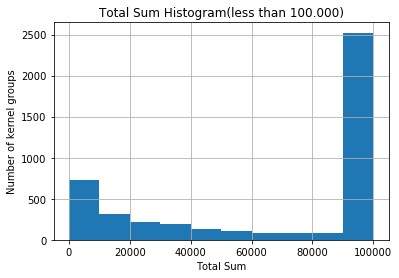

In [109]:
plt.hist(maxmin)
plt.xlabel('Total Sum')
plt.ylabel('Number of kernel groups')
plt.title('Total Sum Histogram(less than 100.000)')
# plt.text(60, .025, r'')
plt.grid(True)
plt.show()

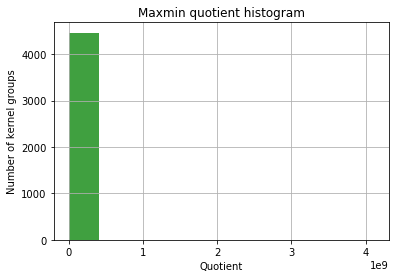

In [92]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Fixing random state for reproducibility
# np.random.seed(19680801)

# mu, sigma = 100, 15
# x = mu + sigma * np.random.randn(10000)

# the histogram of the data
n, bins, patches = plt.hist(maxmin, bins = 10, facecolor='g', alpha=0.75)


plt.xlabel('Quotient')
plt.ylabel('Number of kernel groups')
plt.title('Maxmin quotient histogram')
# plt.text(60, .025, r'')
plt.grid(True)
plt.show()

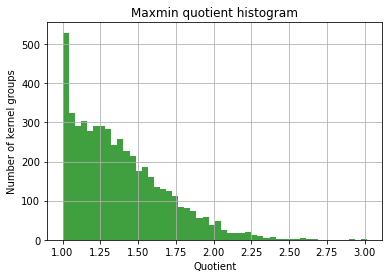

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

mu, sigma = 0, 0.5
x = mu + sigma * np.random.randn(10000) + 1
xnew = list()
for i in range(len(x)):
    if x[i] > 1:
        xnew.append(x[i])
for i in range(250):
    xnew.append(1.0)
# the histogram of the data
n, bins, patches = plt.hist(xnew, 50, facecolor='g', alpha=0.75)


plt.xlabel('Quotient')
plt.ylabel('Number of kernel groups')
plt.title('Maxmin quotient histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.xlim(40, 160)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

In [51]:
df.loc[list(grouped.groups.values())[0], 'price']

0           84.53
7355        92.76
8425      4000.40
9557       316.74
11859       26.00
13957       32.00
14494       52.15
19375       41.33
20218      450.00
20684       93.25
21522      335.05
22910      199.26
23994       10.00
24997      202.19
30729       18.00
35628      320.00
36573       48.65
43675      510.70
72893        1.47
95562      199.10
95577      654.50
101941      42.00
Name: price, dtype: float64

In [49]:
grouped.groups

{(-1,
  '№1',
  'liquid'): Int64Index([     0,   7355,   8425,   9557,  11859,  13957,  14494,  19375,
              20218,  20684,  21522,  22910,  23994,  24997,  30729,  35628,
              36573,  43675,  72893,  95562,  95577, 101941],
            dtype='int64'),
 (0, '№28', 'tablet'): Int64Index([1, 19376, 36688, 69867], dtype='int64'),
 (1, '№10', 'tablet'): Int64Index([2, 19377, 77643], dtype='int64'),
 (2,
  '№10',
  'liquid'): Int64Index([3, 14994, 14996, 18451, 19378, 88822, 102357, 109069], dtype='int64'),
 (5, '№1', 'liquid'): Int64Index([4, 19379], dtype='int64'),
 (8,
  '№20',
  'tablet'): Int64Index([5, 8, 18730, 19356, 19357, 32229, 40586, 40587, 56387], dtype='int64'),
 (9, '№6', 'tablet'): Int64Index([6, 6643, 19346, 40576], dtype='int64'),
 (10, '№1', 'powder'): Int64Index([7, 19347, 40577, 55234], dtype='int64'),
 (11,
  '№1',
  'powder'): Int64Index([9, 18731, 19358, 40588, 43228, 80659], dtype='int64'),
 (12,
  '№1',
  'powder'): Int64Index([10, 19359, 40589, 61

In [ ]:
print(df_new['sum'].astype('float32').sum()/df_old['sum'].astype('float32').sum())
print(len(df_new)/len(df_old))


In [ ]:
len(df_new)

In [ ]:
96.6 * 90.2

# possibly

In [ ]:
https://www.rlsnet.ru/books_book_id_3_page_4.htm
аэроз. - аэрозоль
аэроз.доз. - аэрозоль дозированный
аэроз.доз.мите - аэрозоль дозированный с минимальной дозировкой/действием
аэроз.доз.форте - аэрозоль дозированный с максимальной дозировкой/действием
аэроз.ингал. - аэрозоль ингаляционный
аэроз.ингал.доз. - аэрозоль ингаляционный дозированный
аэроз.наз. - аэрозоль назальный
аэроз.наз.доз. - аэрозоль назальный дозированный
аэроз.наружн. - аэрозоль для наружного применения
аэроз.орал. - аэрозоль для перорального применения
аэроз.орал.доз. - аэрозоль для перорального применения дозированный
бальзам наружн. - бальзам для наружного применения
бальзам орал. - бальзам для перорального применения
бинт/салф.стерил. - бинт с салфеткой стерильные
брикеты парафин. - брикеты парафиновые
брикеты пиротехн. - брикеты пиротехнические
вспомог. в-ва - вспомогательные вещества
гель ваг. - гель вагинальный
гель глазн. - гель глазной
гель д/волос - гель для волос
гель зубн. - гель зубной
гель наз. - гель для носа
гель наружн. - гель для наружного применения
гель орал. - гель для перорального применения
гель рект. - гель ректальный
гель стер. - гель стерильный
гель стомат. - гель стоматологический
гель форте - гель с максимальной дозировкой/действием
гель-ТДТС - гель – трансдермальная терапевтическая система
генератор инсектиц.дыма - генератор инсектицидного дыма
гран. - гранулы
гран.в/п - гранулы для приготовления раствора для внутриполостного введения
гран.д/капель - гранулы для приготовления капель
гран.д/р-ра орал. - гранулы для приготовления раствора для перорального применения
гран.д/рассас. - гранулы для рассасывания
гран.д/сиропа - гранулы для приготовления сиропа
гран.д/сусп. - гранулы для приготовления суспензии
гран.д/сусп.д/ин. - гранулы для приготовления суспензии для инъекций
гран.д/сусп.орал. - гранулы для приготовления суспензии для перорального применения
гран.д/сусп.орал.детск. - гранулы для приготовления суспензии для перорального применения для детей
гран.детск. - гранулы для детей
гран.доз. - гранулы дозированные
гран.доз.д/р-ра орал. - гранулы дозированные для приготовления раствора для перорального применения
гран.доз.д/р-ра орал.детск. - гранулы дозированные для приготовления раствора для перорального применения для детей
гран.доз.форте - гранулы дозированные с максимальной дозировкой/действием
губка стер. - губка стерильная
губка стер.пресс. - губка стерильная прессованная
драже жев. - драже жевательное
драже пролонг. - драже пролонгированного действия
драже форте - драже с максимальной дозировкой/действием
жидк. - жидкость
жидк./комплект - жидкость в комплекте
жидк.д/ин. - жидкость для инъекций
жидк.д/ингал.наркоза - жидкость для ингаляционного наркоза
жидк.д/снятия лака - жидкость для снятия лака
жидк.наружн. - жидкость для наружного применения
жидк.орал. - жидкость для перорального применения
имплант. - имплантаты
ингал.карман. - ингалятор карманный
каплеты детск. - каплеты для детей
каплеты п.о. - каплеты, покрытые оболочкой
капли глазн. - капли глазные
капли глазн./наз. - капли глазные и для носа
капли глазн./ушн. - капли глазные и ушные
капли д/ингал. - капли для ингаляций
капли детск. - капли детские
капли зубн. - капли зубные
капли наз. - капли для носа
капли наз.детск. - капли для носа детские
капли наружн. - капли для наружного применения
капли орал. - капли для перорального применения
капли орал. и д/ингал. - капли для перорального применения и для ингаляций
капли орал./наружн. - капли для перорального и наружного применения
капли орал.детск. - капли для перорального применения детские
капли ушн. - капли ушные
капс. - капсулы
капс./чай лек. - капсулы с чаем лекарственным
капс.д/имплант. - капсулы для имплантаций
капс.д/имплант.депо - капсулы для имплантаций пролонгированного действия
капс.д/ин.депо - капсулы для инъекций пролонгированного действия
капс.депо - капсулы депо
капс.детск. - капсулы для детей
капс.мягк. - капсулы мягкие
капс.мягк.форте - капсулы мягкие форте
капс.наружн. - капсулы для наружного применения
капс.пролонг. - капсулы пролонгированного действия
капс.раствор./кишечн. - капсулы, растворимые в кишечнике
капс.рект. - капсулы ректальные
капс.рект.детск. - капсулы ректальные для детей
капс.ретард - капсулы ретард
капс.ретард.форте - капсулы ретард с максимальной дозировкой/действием
капс.тверд. - капсулы твердые
капс.форте - капсулы с максимальной дозировкой/действием
карандаш мед. - карандаш медицинский
клей фибрин. - клей фибриновый
композ. - композиция
контрац.в/мат. - контрацептив внутриматочный
конусы зубн. - конусы зубные
конц. - концентрат
конц.д/дез.р-ра - концентрат для приготовления дезинфекционного раствора
конц.д/ин. - концентрат для приготовления инъекций
конц.д/инф. - концентрат для приготовления инфузий
конц.д/инф. и д/р-ра орал. - концентрат для приготовления инфузий и раствора для перорального применения
конц.д/р-ра наружн. - концентрат для приготовления раствора для наружного применения
конц.д/р-ра орал. - концентрат для приготовления раствора для перорального применения
конц.жидк. - концентрат жидкий
конц.наружн. - концентрат для наружного применения
конц.наружн./орал. - концентрат для наружного и перорального применения
конц.орал. - концентрат для перорального применения
корневища и корни/брикеты - корневища и корни в брикетах
корневища с корнями/брикеты - корневища с корнями в брикетах
корневища/брикеты - корневища в брикетах
корни/брикеты - корни в брикетах
крем ваг. - крем вагинальный
крем д/лица - крем по уходу за кожей лица
крем д/рук - крем по уходу за кожей рук
крем детск. - крем для детей
крем наз. - крем для носа
крем-субст. - крем–субстанция для приготовления косметических средств
кубики орал. - кубики для перорального применения
лак д/ногтей - лак для ногтей
лак инсект. - лак инсектицидный
лек.раст.сырье - лекарственное растительное сырье
лента бум. - лента бумажная
линим. - линимент
листья/брикеты - листья в брикетах
лосьон детск. - лосьон детский
мазь ваг. - мазь вагинальная
мазь глазн. - мазь глазная
мазь жирн. - мазь жирная
мазь интраназ. - мазь для носа
мазь п/жирн. - мазь полужирная
мазь рект. - мазь ректальная
мазь-ТДТС - мазь – трансдермальная терапевтическая система
маска д/лица - маска по уходу за кожей лица
масло детск. - масло детское
масло наружн. - масло для наружного применения
маты инсектиц. - маты инсектицидные
мк/гран. - микрогранулы
мк/гран.доз. - микрогранулы дозированные
мк/драже - микродраже
мк/капс. - микрокапсулы
мк/капс.д/ин. - микрокапсулы для приготовления раствора для инъекций
мк/сферы лиоф.д/ин. - микросферы лиофилизированные для инъекций
молочко д/лица - молочко по уходу за кожей лица
мыло жидк. - мыло жидкое
набор диагн. - набор диагностический
набор диагн.многокомп. - набор диагностический многокомпонентный
настойка матр. - настойки матричные
нити зубн. - нити зубные
обр.станд. - стандартные образцы лекарственных средств
оподельдок - оподельдоки
основа д/мазей - основа для мазей
основа д/супп. - основа для суппозиториев
паста зубн. - паста зубная
паста орал. - паста для перорального применения
паста стомат. - паста стоматологическая
пастилки детск. - пастилки для детей
пена д/ванн - пена для ванн
пластина п.о. - пластина, покрытая оболочкой
пластина бум. - пластина бумажная
пластина пиротехн. - пластина пиротехническая
пластырь форте - пластырь с максимальной дозировкой/действием
пластырь-ТДТПС - пластырь – трансдермальная терапевтическая проводящая система
пластырь-ТДТС - пластырь – трансдермальная терапевтическая система
пластырь-ТДТС форте - пластырь – трансдермальная терапевтическая система с максимальной дозировкой/действием
пластырь/компл. - пластыри в комплекте
пленка интраваг. - пленка интравагинальная
пленки глазн.лек. - пленки глазные лекарственные
пломб.мат. - пломбировочные материалы
повязка 1-слойн. - повязка однослойная
полоски воск. - полоски восковые
пор. - порошок
пор.д/вдув. - порошок для вдуваний
пор.д/ветерин. - порошок для использования в ветеринарии
пор.д/дез.р-ра - порошок для приготовления дезинфекционного раствора
пор.д/ин. - порошок для приготовления раствора для инъекций
пор.д/ин.в/в - порошок для приготовления инъекционного раствора для в/в введения
пор.д/ин.в/в и в/м - порошок для приготовления раствора для в/в и в/м введения
пор.д/ин.в/в кап. - порошок для приготовления инъекционного раствора для в/в капельного введения
пор.д/ин.в/в стр. - порошок для приготовления инъекционного раствора для в/в струйного введения
пор.д/ин.в/м - порошок для приготовления инъекционного раствора для в/м введения
пор.д/ингал. - порошок для ингаляций/вдыхания
пор.д/ингал.доз. - порошок для ингаляций/вдыхания дозированный
пор.д/инф. - порошок для приготовления инфузионного раствора
пор.д/капель - порошок для приготовления капель
пор.д/капель глазн. - порошок для приготовления глазных капель
пор.д/капель орал.детск. - порошок для приготовления капель для перорального применения для детей
пор.д/маски д/лица - порошок для приготовления маски по уходу за кожей лица
пор.д/р-ра - порошок для приготовления раствора
пор.д/р-ра наружн. - порошок для приготовления раствора для наружного применения
пор.д/р-ра орал. - порошок для приготовления раствора для перорального применения
пор.д/р-ра орал.детск. - порошок для приготовления раствора для перорального применения для детей
пор.д/сиропа - порошок для приготовления сиропа
пор.д/сусп. - порошок для приготовления суспензии
пор.д/сусп.детск. - порошок для приготовления суспензии детской
пор.д/сусп.орал. - порошок для приготовления суспензии для перорального применения
пор.д/сусп.орал.детск. - порошок для приготовления суспензии для перорального применения для детей
пор.д/сусп.орал.форте - порошок для приготовления суспензии для перорального применения с максимальной дозировкой/действием
пор.д/сусп.форте - порошок для приготовления суспензии с максимальной дозировкой/действием
пор.д/чая - порошок для приготовления чая
пор.доз. - порошок дозированный
пор.доз.д/р-ра орал.детск. - порошок дозированный для приготовления раствора для перорального применения для детей
пор.доз.детск. - порошок дозированный детский
пор.зубн. - порошок зубной
пор.лиоф. - порошок лиофилизированный
пор.лиоф.д/ин. - порошок лиофилизированный для приготовления инъекционного раствора
пор.лиоф.д/ингал. - порошок лиофилизированный для ингаляций
пор.лиоф.д/инф. - порошок лиофилизированный для приготовления инфузионного раствора
пор.лиоф.д/р-ра в/в - порошок лиофилизированный для приготовления раствора для в/в введения
пор.лиоф.д/р-ра наз. - порошок лиофилизированный для приготовления раствора для интраназального применения
пор.лиоф.д/р-ра наружн. - порошок лиофилизированный для приготовления раствора для наружного применения
пор.лиоф.д/р-ра орал. - порошок лиофилизированный для приготовления раствора для перорального применения
пор.лиоф.доз. - порошок лиофилизированный дозированный
пор.наружн. - порошок для наружного применения
пор.орал. - порошок для перорального применения
пор.раствор. - порошок растворимый
пор.смачив. - порошок смачивающийся
пор.стер. - порошок стерильный
пор.шип. - порошок для приготовления шипучего напитка
пор.шип.доз. - порошок для приготовления шипучего напитка дозированный
приманка в контейн. - приманка в контейнере
приманка/гран. - приманка гранулированная
присыпка детск. - присыпка детская
р-р - раствор
р-р в/п - раствор для внутриполостного введения
р-р гемоконсерванта - раствор гемоконсерванта
р-р гемоконсерванта/компл. - раствор гемоконсерванта в комплекте
р-р д/диализа - раствор для диализа
р-р д/жестк.конт.линз - раствор для обработки и хранения жестких контактных линз
р-р д/ин. - раствор для инъекций
р-р д/ин.внутриглазн. - раствор для инъекций внутриглазных
р-р д/ин.депо - раствор для инъекций пролонгированного действия
р-р д/ин.изотон. - раствор для инъекций изотонический
р-р д/ин.масл. - раствор для инъекций масляный
р-р д/ин.масл.в/м - раствор для инъекций масляный для внутримышечного введения
р-р д/ин.п/к - раствор для подкожных инъекций
р-р д/ин.спирт. - раствор для инъекций спиртовой
р-р д/ингал. - раствор для ингаляций
р-р д/ингал.детск. - раствор для ингаляций детский
р-р д/ингал.наркоза - раствор для ингаляционного наркоза
р-р д/инф. - раствор для инфузий
р-р д/конт.линз - раствор для обработки и хранения контактных линз
р-р д/мягк.конт.линз - раствор для обработки и хранения мягких контактных линз
р-р д/перитон.диализа - раствор для перитонеального диализа
р-р дез. - раствор дезинфекционный
р-р инсект. - раствор инсектицидный
р-р ирригац. - раствор ирригационный
р-р масл. - раствор масляный
р-р масл.наружн. - раствор масляный для наружного применения
р-р масл.наружн. и д/ингал. - раствор масляный для наружного применения и для ингаляций
р-р масл.орал. - раствор масляный для перорального применения
р-р наружн. - раствор для наружного применения
р-р наружн. и д/ингал. - раствор для наружного применения и для ингаляций
р-р наружн.стер. - раствор для наружного применения стерильный
р-р орал. - раствор для перорального применения
р-р орал. и д/ингал. - раствор для перорального применения и для ингаляций
р-р орал.детск. - раствор для перорального применения детский
р-р рект. - раствор для ректального применения
р-р спирт. - раствор спиртовой
р-р спирт.наружн. - раствор спиртовой для наружного применения
р-р спирт.орал. - раствор спиртовой для перорального применения
р-р стер. - раствор стерильный
р-р стомат. - раствор стоматологический
р-р сублингв. - раствор для сублингвального применения
резин.жев. - резинка жевательная
салф.с дез.р-ром - салфетки, пропитанные дезраствором
салф.стерил. - салфетка стерильная
сбор лек. - сборы лекарственные
сбор лек./брикеты - сбор лекарственный в брикетах
сироп д/новорожд. - сироп для новорожденных
сироп детск. - сироп для детей
сироп форте - сироп с максимальной дозировкой/действием
смесь парогаз. - смесь парогазовая
смесь пиротехн. - смесь пиротехническая
смесь сух. - смесь сухая
спрей доз. - спрей дозированный
спрей наз. - спрей назальный
спрей наз.детск. - спрей назальный для детей
спрей наз.доз. - спрей назальный дозированный
спрей наружн. - спрей для наружного применения
спрей-гель форте - спрей–гель с максимальной дозировкой/действием
субст. - субстанция
субст.-гран. - субстанция–гранулы
субст.-пор. - субстанция–порошок
субст.д/инф. - субстанция для инфузий
субст.жидк. - субстанция жидкая
субст.крист. - субстанция кристаллическая
субст.лиоф. - субстанция лиофилизированная
субст.масл. - субстанция масляная
субст.н/стаб. - субстанция нестабилизированная
субст.стаб. - субстанция стабилизированная
субст.стер. - субстанция стерильная
супп. - суппозитории
супп.ваг. - суппозитории вагинальные
супп.детск. - суппозитории детские
супп.рект. - суппозитории ректальные
супп.рект.д/новорожд. - суппозитории ректальные для новорожденных
супп.рект.детск. - суппозитории ректальные детские
супп.уретр. - суппозитории уретральные
сусп. - суспензия
сусп.глазн. - суспензия глазная
сусп.д/ин. - суспензия для инъекций
сусп.д/ин. и наз. - суспензия для инъекций и интраназального введения
сусп.д/ин.депо - суспензия для инъекций пролонгированного действия
сусп.д/ин.детск. - суспензия для инъекций детская
сусп.д/ин.масл. - суспензия для инъекций масляная
сусп.д/ингал. - суспензия для ингаляций
сусп.интратрахеальн. - суспензия для интратрахеального введения
сусп.интратрахеальн.детск. - суспензия для интратрахеального введения детская
сусп.мк/капс. - суспензия микрокапсулированная
сусп.орал. - суспензия для перорального применения
сусп.орал.детск. - суспензия для перорального применения детская
сусп.орал.доз. - суспензия для перорального применения дозированная
сусп.орал.форте - суспензия для перорального применения с максимальной дозировкой/действием
сусп.рект. - суспензия для ректального введения
сырье д/БАД - сырье для производства биологически активных добавок
табл. - таблетки
табл./комплект - таблетки в комплекте
табл.ваг. - таблетки вагинальные
табл.д/ветерин. - таблетки для применения в ветеринарии
табл.д/имплант. - таблетки для имплантаций
табл.д/капель глазн. - таблетки для приготовления глазных капель
табл.д/пасты - таблетки для приготовления пасты
табл.д/р-ра глазн. - таблетки для приготовления офтальмологического раствора
табл.д/р-ра наружн. - таблетки для приготовления раствора для наружного применения
табл.д/р-ра орал. - таблетки для приготовления раствора для перорального применения
табл.д/рассас. - таблетки для рассасывания
табл.дел. - таблетки делимые
табл.депо - таблетки депо
табл.детск. - таблетки для детей
табл.детск.дел. - таблетки для детей делимые
табл.детск.дисперг.аромат. - таблетки для детей диспергируемые, ароматизированные
табл.детск.раствор. - таблетки для детей растворимые
табл.детск.раствор.аромат. - таблетки для детей растворимые ароматизированные
табл.дисперг. - таблетки диспергируемые
табл.дисперг.форте - таблетки диспергируемые с максимальной дозировкой/действием
табл.жев. - таблетки жевательные
табл.жев.детск. - таблетки жевательные для детей
табл.лингв. - таблетки лингвальные
табл.масса - таблетируемая масса
табл.мите - таблетки с минимальной дозировкой/действием
табл.п.о. - таблетки, покрытые оболочкой (филмтаблетки)
табл.п.о.д/сусп.орал. - таблетки, покрытые оболочкой, для приготовления суспензии для перорального применения
табл.п.о.дел. - таблетки, покрытые оболочкой, делимые
табл.п.о.депо - таблетки, покрытые оболочкой, депо
табл.п.о.детск. - таблетки, покрытые оболочкой, для детей
табл.п.о.мите - таблетки, покрытые оболочкой, с минимальной дозировкой/действием
табл.п.о.пролонг. - таблетки, покрытые оболочкой, пролонгированного действия
табл.п.о.пролонг.мите - таблетки, покрытые оболочкой, пролонгированного действия с минимальной дозировкой/действием
табл.п.о.пролонг.форте - таблетки, покрытые оболочкой, пролонгированного действия с максимальной дозировкой/действием
табл.п.о.раствор./желуд. - таблетки, покрытые оболочкой, растворимые в желудке
табл.п.о.раствор./кишечн. - таблетки, покрытые оболочкой, растворимые в кишечнике
табл.п.о.раствор./кишечн.ретард - таблетки, покрытые оболочкой, растворимые в кишечнике, пролонгированного действия
табл.п.о.ретард - таблетки, покрытые оболочкой, ретард
табл.п.о.форте - таблетки, покрытые оболочкой, с максимальной дозировкой/действием
табл.п.о.шип. - таблетки, покрытые оболочкой, шипучие
табл.пиротехн. - таблетки пиротехнические
табл.пролонг. - таблетки пролонгированного действия
табл.пролонг.дел. - таблетки пролонгированного действия делимые
табл.раствор. - таблетки растворимые
табл.раствор./желуд. - таблетки, растворимые в желудке
табл.раствор./кишечн. - таблетки, растворимые в кишечнике
табл.ретард - таблетки ретард
табл.семи - таблетки со средней дозировкой/действием
табл.суббукк. - таблетки защечные, или суббуккальные
табл.сублингв. - таблетки сублингвальные
табл.ультраретард - таблетки ультраретард
табл.форте - таблетки с максимальной дозировкой/действием
табл.шип. - таблетки для приготовления шипучего напитка
табл.шип.дел. - таблетки для приготовления шипучего напитка делимые
тамп.стомат. - тампоны стоматологические
ТДТПС - трансдермальная терапевтическая проводящая система
ТДТС - трансдермальная терапевтическая система
тоник д/лица - тоник по уходу за кожей лица
трава/брикеты - трава в брикетах
трит. - тритурации
ТС - терапевтические системы
филмтабл. - филмтаблетки
филмтабл.детск. - филмтаблетки детские
филмтабл.форте - филмтаблетки с максимальной дозировкой/действием
цветки/брикеты - цветки в брикетах
чай лек. - чай лекарственный
чай лек.детск. - чай лекарственный детский
шамп. - шампунь
шамп.-кондицион. - шампунь–кондиционер
шамп.косметич. - шампуни косметические
шнур пиротехн. - шнур пиротехнический
щетка зубн. - щетка зубная
экстр. - экстракты
экстр.густ. - экстракт густой
экстр.жидк. - экстракт жидкий
экстр.жидк.д/ин. - экстракт жидкий для инъекций
экстр.жидк.комб. - экстракт жидкий комбинированный
экстр.жидк.орал. - экстракт жидкий для перорального применения
экстр.масл. - экстракт масляный
экстр.масл.наружн. - экстракт масляный для наружного применения
экстр.сух. - экстракт сухой
эл.фумигатор - электрофумигатор
эликсир детск. - эликсир для детей
эмульс. - эмульсия
эмульс.д/ин. - эмульсия для инъекций
эмульс.д/ин.в/в - эмульсия для инъекций внутривенных
эмульс.д/ингал. - эмульсия для ингаляций
эмульс.д/инф. - эмульсия для инфузий
эмульс.инсект. - эмульсия инсектицидная
эмульс.наз. - эмульсия для носа
эмульс.наружн. - эмульсия для наружного применения
эмульс.оральн. - эмульсия для перорального применения

# OLD

## Clusterization with med_dic

In [ ]:

# classification of one-word prodcuts
from libs.cluster import simple
df_final, med_dic = simple(df)

In [ ]:
len(df), len(df_final)

# ------------------------------------------

# ------------------------------------------

# analyze non-matched products

In [ ]:
df_final.head()

In [ ]:
'лопирел' in list(med_dic['name'])

In [ ]:
df.head()

In [ ]:
df_merged = df.merge(df_final, how='left', on='_id')





In [ ]:
df_merged.head()

In [ ]:
df_merged = df_merged[df_merged['len_y'].isna()]

In [ ]:
len(df_merged)

In [ ]:
len(df)

In [ ]:
df_merged.head(5)

In [ ]:
print("SUM OF ALL LOTS:", df['sum'].sum())
print("SUM OF ALL UNCLASSIFIED:", df_merged['sum_x'].sum())
print("PART:", df_merged['sum_x'].sum()/df['sum'].sum())

# med_dic frequency dictionary

In [ ]:
from collections import defaultdict
med_dic_freq = defaultdict(int)

for key in med_dic['name']:
    med_dic_freq[key] = df['product_name'].apply(lambda x : key in x).sum()

In [ ]:
med_dic_freq_sorted = sorted(med_dic_freq.items(), key=lambda kv: -kv[1])
med_dic_freq_sorted[:200]

In [ ]:
[('п', 71944),
 ('ц', 22922),
 ('дства', 8625),
 ('едства', 8619),
 ('действ', 5499),
 ('лек', 3713),
 ('систем', 3711),
 ('цен', 3222),
 ('гр', 2463),
 ('инг', 2007),
 ('упаковки', 1637),
 ('лекарств', 1421),
 ('фарм', 1374),
 ('ингаляционного', 894),
 ('лп', 852),
 ('прам', 843),
 ('препаратов', 658),
 ('комплекте', 646),
 ('наименован', 331),
 ('действующих', 326),
 ('включая', 276),
 ('шприц', 264),
 ('противосуд', 174),
 ('наркотических', 97),
 ('нейролептические', 87),
 ('вода', 81),
 ('on', 75),
 ('анестезии', 58),
 ('медикаменты', 57),
 ('прочих', 42),
 ('вегетативную', 39),
 ('брал', 39),
 ('риской', 39),
 ('системы', 38),
 ('действующе', 34),
 ('лекарства', 33),
 ('седотивные', 30),
 ('нейролептики', 30),
 ('сильнодействующие', 26),
 ('анальгетики', 25)]

### Recursive Levenshtein Function

In [ ]:
from libs.ld import LD

print(LD("Python", "Peithen"))

##### Takes too long to execute

### Highly Effective Levenstein Function

In [ ]:
from libs.ld import LDfast


print(LDfast("Python", "Peithen"))
# print("The function was called " + str(levenshtein.calls) + " times!")

new_med_dic = set(list(med_dic['name']))
from collections import defaultdict
med_dic_typo = defaultdict(int)

typo_dict = defaultdict(str)
med_dic_list = list(med_dic['name'])
for i in range(len(med_dic_list) - 1):
    if typo_dict[med_dic_list[i]] == '':
        typo_dict[med_dic_list[i]] =med_dic_list[i]
    for j in range(i + 1, len(med_dic_list)):
        if (LDfast(med_dic_list[i], med_dic_list[j]) <= 1):
            med_dic_typo[med_dic_list[i]] += 1
            try:
                print(med_dic_list[j], med_dic_list[i])
                typo_dict[med_dic_list[j]] =med_dic_list[i]
                new_med_dic.remove(med_dic_list[j])
            except KeyError:
                pass 
    if not (i % 120):
        print(i)
        LDfast.cache_clear()

In [ ]:
import pickle

In [ ]:
pickle.dump(typo_dict, open( "typodict.p", "wb" ) )
pickle.dump(new_med_dic, open( "newmeddic.p", "wb" ) )

In [ ]:
typo_dict = pickle.load( open( "typodict.p", "rb" ) )
new_med_dic = pickle.load( open( "newmeddic.p", "rb" ) )

In [ ]:
len(new_med_dic)

In [ ]:
len(med_dic)

In [ ]:
# sorted_typo = sorted(med_dic_typo.items(), key=lambda kv: -kv[1])
# print(sorted_typo)

In [ ]:
print("NUMBER OF TYPOS : ", len(med_dic) - len(new_med_dic))

In [ ]:
type(new_med_dic)

## Word2Vec

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
import zipfile
model_file = '180.zip'
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

In [ ]:
'день_NOUN' in model

In [ ]:
k = 0
for word in new_med_dic:
    if (word + '_NOUN') in model or (word + '_ADJ') in model or (word + '_VERB') in model:
        print(word)
        k += 1
print(k)

In [ ]:
def rm(word):
    new_med_dic.remove(word)
for w in ['масса', 'вода', 'кофеин', 'прочее', 'лирика', 'доставка']:
    rm(w)

#### Let's try lemmatize new_med_dic entries

In [ ]:
from pymystem3 import Mystem
text = "Красивая мама красиво мыла раму"
m = Mystem()
lemmas = m.lemmatize(text)
print(''.join(lemmas))

In [ ]:
m.lemmatize('медицинские')[0]

#### takes too much time

## New med_dic

In [ ]:
new_med_dic_list = list(new_med_dic)
n = len(new_med_dic_list)
new_med_dic_tuple = [(new_med_dic_list[i], i) for i in range(n)]

In [ ]:
new_med_dic_pd = pd.DataFrame(new_med_dic_tuple, columns = ['name', 'class'], index = [i for i in range(n)]) 

In [ ]:
### fix typos
def typo_fix(list_of_words):
    new_list = list()
    for w in list_of_words:
        new_list.append(typo_dict[w])
    return new_list

In [ ]:
typo_dict['пирецетам']

In [ ]:
### fix typos
df['name_del'] = df['name_del'].apply(typo_fix)
df_len1=df[df['len']==1]
df_len1['name']=df_len1['name_del'].apply(lambda x: x[0])

df_len1=pd.merge(df_len1, new_med_dic_pd, on='name', how='left')

# classification of more-than-one-word prodcuts w.r.t. one-word-products
df_len2=df[df['len']>1]

def search_list(doc):
    for w in doc:
        ind=[i for i, j in enumerate(new_med_dic_pd['name']) if j == w]    
        if len(ind)>0:
            return new_med_dic_pd.loc[ind[0],'class']
    return 

df_len2['class']=df_len2['name_del'].apply(search_list)
df_len2=pd.merge(df_len2, new_med_dic_pd, on='class', how='left')
# Check classes if needed
#df_len2['class'].isna().sum()
#freqs = Counter(df_len2['class'])
#pop_class=[cl[0] for cl in freqs.most_common()[0:50]]

df_final=pd.concat([df_len1,df_len2])
df_final=df_final[df_final['class'].isna()==0]
df_final['name_del_text']=df_final['name_del'].apply(lambda x: ' ' + ' '.join(x) + ' ')
df_final['number']=df_final['number'].apply(lambda x: x.replace('№',''))
df_final=df_final.drop(['name','name_del','name_word'], axis=1)


import csv
df_final.to_csv('medical_2012_class_new.csv', sep=';',quoting=csv.QUOTE_NONNUMERIC)

In [ ]:
type_dict={'tablet':['таблетки', 'таблетка', 'таб', 'таблет', 'тб', 'тбт', 'табл', 'драже', 'др', 'драж', 'капс', 'капсула', 'капсулы'],
           'cream':['мазь', 'мз', 'мзь', 'эмульс', 'эмульсия'],
           'powder':['пор', 'порошок'],
           'liquid':['рр','рас','раст', 'раств', 'раствор', 'концентрат', 'конц', 'сусп', 'сироп', 'сир'],
           'capsule':['амп', 'ампулы', 'ампула'],
           'spray': ['спрей', 'спр', 'аэр', 'аэрозоль', 'аэроз'],
           'dropley':['капли', 'каплях', 'капл', 'кап']           
           }

types = list(type_dict.keys())

types.append('unknown')

types

## Full data

In [ ]:
col_type={'_id': str,
           'cont_num':str,
           'sign_date':str,
           'custom_regnum':str,
           'product_name':str,
           'okdp_code':str,
           'okei_code':str,
           'quantity':float,
           'price':float,
           'sum':float
           }

df = pd.read_csv('datascript/medical_2012_fulldata.csv', sep=';',dtype=col_type)
df = df.dropna()
df = df.drop(['cont_num', 'sign_date', 'custom_regnum', 'okdp_code', 'okei_code'], axis=1)

df['name_norm']=df['product_name'].map(lambda x: re.sub(r'(\D)\.', r'\1. ',x))  # delete symbol point everywhere except for in numbers
df['name_norm']=df['name_norm'].map(lambda x: x.lower())
df['name_norm']=df['name_norm'].map(lambda x: x.replace('№ ','№')) 
df['name_norm']=df['name_norm'].map(lambda x: re.sub(r' n(\d+)| n (\d+)| no(\d+)| no (\d+)', r' №\1',x)) 

mystoplist=[' для ',' д/', ' и ', ' в ',' с ',' у ', ' на ', ' а ',' не ', ' о ']# need also exclude \\dlya
# stoplist = [' ' + stopword + ' ' for stopword in list(stop)]
# mystoplist += stoplist
my_regex = re.compile('|'.join(mystoplist))
df['name_norm']=df['name_norm'].apply(lambda x: my_regex.sub(' ',x)) 
df['name_norm']=df['name_norm'].apply(lambda x: x.replace(':',' ')) 
#punctuation=''.join([sim for sim in list(punctuation) if sim not in ['%',',']]) # list of simbols not to delete

translator = str.maketrans('','',punctuation) 
df['name_norm']=df['name_norm'].map(lambda x: x.translate(translator))

In [ ]:
df_small = pd.read_csv('datascript/medical_2012.csv', sep=';',dtype=col_type)

In [ ]:
len(df_small)

In [ ]:
df['weight']=df['product_name'].apply(weight_mg) + 1000 * df['product_name'].apply(weight_g)

In [ ]:
df['number']=df['name_norm'].apply(prod_number)
# comment it later. it deletes all numbers
df['name_norm']=df['name_norm'].map(lambda x: re.sub('№', '',x))
df['name_norm']=df['name_norm'].map(lambda x: re.sub('\d+', '',x))

df['name_word']=df['name_norm'].map(lambda x : word_tokenize(x))

type_dict={'tablet':['таблетки', 'таблетка', 'таб', 'таблет', 'тб', 'тбт', 'табл', 'драже', 'др', 'драж', 'капс', 'капсула', 'капсулы'],
           'cream':['мазь', 'мз', 'мзь', 'эмульс', 'эмульсия'],
           'powder':['пор', 'порошок'],
           'liquid':['рр','рас','раст', 'раств', 'раствор', 'концентрат', 'конц', 'сусп', 'сироп', 'сир'],
           'capsule':['амп', 'ампулы', 'ампула'],
           'spray': ['спрей', 'спр', 'аэр', 'аэрозоль', 'аэроз'],
           'dropley':['капли', 'каплях', 'капл', 'кап']           
           }
# import pycountry # use it later
countr_list=['австрия','франция','польша','россия','украина', 'латвия', 'мальта', 'хорватия'] # use it later
          

df['type']=df['name_word'].apply(prod_type)


freqs = Counter(df['type'])
freqs.most_common()


df['name_del']=df['name_word'].apply(del_list, dic=type_dict)
#one more round of name_del
df['name_del']=df['name_del'].apply(del_list, dic=type_dict)
df['name_del_text']=df['name_del'].apply(lambda x: ' ' + ' '.join(x) + ' ')
okdp_list=[str(okdp) for okdp in range(2423210,2423220)] # modify for more products

del_dict={'okdp':okdp_list,
          'word1':['средства', 'противосудорожные','действующие', 'центральную', 'нервную', 'снотворные', 'наркоза', 'систему', 'прочие', 'препараты', 'влияющие', ','],
          'word2':['покрытые','внутримышечного','возбуждающие','влияющих','нейроплегические','лекарственный','средствадействующие','лекарственные','лекарственных','н','пролонгированного','наркотические','седативные','','средств','введения','внутривенного','инъекций','оболочкой','по','поб','пленочной','действия','внутрь', 'приема', 'введ', 'поставка'],
          'help':['вв','вм','мгмл','мг','мл','г', '№','мс'], # delete this category later
          'counry': countr_list # delete this category later
          }

df['name_del']=df['name_del'].apply(del_list, dic=del_dict)

df['len']=df['name_del'].apply(lambda x: len(x))
df=df[df['len']>0]

In [ ]:
# classification of one-word prodcuts
df_len1=df[df['len']==1]
df_len1['name']=df_len1['name_del'].apply(lambda x: x[0])

med_dic=df_len1.loc[:,'name']
med_dic=pd.DataFrame(med_dic.drop_duplicates())
med_dic['class']=range(0,len(med_dic['name']))
med_dic['index']=med_dic['class']
med_dic=med_dic.set_index('index')

df_len1=pd.merge(df_len1, med_dic, on='name', how='left')

# classification of more-than-one-word prodcuts w.r.t. one-word-products
df_len2=df[df['len']>1]

def search_list(doc):
    for w in doc:
        ind=[i for i, j in enumerate(med_dic['name']) if j == w]    
        if len(ind)>0:
            return med_dic.loc[ind[0],'class']
    return 

df_len2['class']=df_len2['name_del'].apply(search_list)
df_len2=pd.merge(df_len2, med_dic, on='class', how='left')
# Check classes if needed
#df_len2['class'].isna().sum()
#freqs = Counter(df_len2['class'])
#pop_class=[cl[0] for cl in freqs.most_common()[0:50]]

df_final=pd.concat([df_len1,df_len2])
df_final=df_final[df_final['class'].isna()==0]
df_final['number']=df_final['number'].apply(lambda x: x.replace('№',''))
df_final=df_final.drop(['name','name_del','name_word'], axis=1)


import csv
df_final.to_csv('medical_2012_class_full.csv', sep=';',quoting=csv.QUOTE_NONNUMERIC)